# Meal analysis

About 1,300 meal records of 60 persons are provided. Each row indicates 1 meal with several features like person profile, number of dishes, detail nutrients like amount of enerty, carbo, fat, protein and so on. The score is from 1 to 4 and 1 indicates the wrost and 4 does the best meal. 
By using values from “B” to “Q” columns as input features and "R" as target variable, create a classifier to predict the score of meal.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectPercentile, f_classif

## Load the dataset
Load the data set and drop na rows. Split the data set into input features (X) and target variable (y).

In [2]:
# Define a function to load the data set and drop na rows, X is input features and y is target variable
def load_dataset(filename):

    # load the data as pandas Dataframe
    data = pd.read_excel(filename, index_col=[0])
    # drop na of the data
    dataset = data.dropna()
    
    # split into input X and output y variables
    X = dataset.iloc[:, 0:-1]
    y = dataset.iloc[:, -1]

    return X, y


In [3]:
# Load the dataset 
X, y = load_dataset('Meal Analysis (2017) .xlsx')

# Check the top 5 rows to get an idea of what we are dealing with
X.head()


,Type,gender,age,height,weight,EER[kcal],P target(15%)[g],F target(25%)[g],C target(60%)[g],number of dishes,E[kcal],P[g],F[g],C[g],Salt[g],Vegetables[g]
1,breakfast,female,32.0,157.0,48.0,1655,62.043750,45.958333,248.175000,2,333.87,5.85,0.75,75.69,0.21,29.0
2,breakfast,female,35.0,161.0,55.0,2073,77.745091,57.588956,310.980364,2,213.85,4.62,4.48,41.25,0.11,0.0
3,breakfast,female,26.0,159.0,51.0,2042,76.584375,56.729167,306.337500,4,351.59,27.31,18.85,18.10,2.84,116.4
4,breakfast,female,48.0,164.0,57.0,1772,66.431250,49.208333,265.725000,2,295.43,5.63,0.89,65.08,0.65,189.0
5,dinner,female,48.0,164.0,57.0,1772,66.431250,49.208333,265.725000,5,876.19,41.46,34.16,96.30,6.37,53.5


## Encode categorical columns

The features 'Type' and 'gender' are text values, which will be encoded into numerical values for further processing.
'Type' is encoded into 3 values 0, 1 and 2, and 'gender' is encoded into 2 values 0 and 1.

In [4]:
# Save the feature names into a variable 
feature_names = X.columns

# Encode categorical columns
categorical_columns = ['Type', 'gender']
column_trans = make_column_transformer(
    [OrdinalEncoder(), categorical_columns], remainder='passthrough'
)
X = column_trans.fit_transform(X)

# Check the first 20 rows of encoded features
X[:20, :2]

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [2., 0.],
       [0., 0.],
       [1., 0.],
       [2., 0.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [2., 0.],
       [1., 1.],
       [1., 0.],
       [1., 1.],
       [2., 0.],
       [2., 0.],
       [2., 1.],
       [2., 1.]])

## Prepare data 
Split the data into train and test set

In [5]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


## Machine learning pipeline
### Standardization
Standardizing features by removing the mean and scaling to unit variance.
Standardization is commonly required in most machine learning algorithms, especially in Support Vector Machines (SVM).
Standardization makes feature distributions centered around 0 with variance in the same order across all features.
If a features has a variance that is significant larger order than others, it might dominate the classification and make the classifier behave not as well as expected.
### Support Vector Machines (SVM)
Support Vector Machines is chosen as the classification method in this solution for following reasons:

1. It is a supervised learning method, which is applicable to labeled data like ours.
2. It is effective in high dimension spaces, as our data has many features.
3. It works relatively well when there is a clear margin of separation between classes.
4. It is versatile with different kernel functions, it still works even the boundaries between classes are not linear, which is very likely to happen in our data.
5. It is relatively memory efficient since it uses a subset of training points in the decision function.


The Radial Basis Function (RBF) kernel is chosen for our SVM classifier since it is more suitable for non-linear hyperplane boundaries.  

In [6]:
# Setup the pipeline
clf_pipeline = Pipeline(
    [('scaler', StandardScaler()), ('clf', OneVsRestClassifier(svm.SVC(kernel='rbf')))]
)

## Tune hyerparameters using grid search and cross validation
### Regularization
Regularization parameter in python's Scikit-learn package is prepresented by C parameter. C is the penalty parameter, which represents the misclassification or error term.
The misclassification or error term determines how much error is accepted. This controls the trade-off between decision boundary and misclassification term. A smaller C creates a small-margin hyperplane and a larger C creates a larger margin hyperplane.
### Gamma
Gamma determines how much influence a single training example has. A lower Gamma value will fit the training dataset loosely, and a higher Gamma value will fit the training dataset exactly, which might cause over-fitting. 


In [7]:
# Specify the hyperparameter space
parameters = {'clf__estimator__C':[100, 10, 1, 0.1, 0.01], 
              'clf__estimator__gamma':[0.1, 0.01, 0.001]}


# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(clf_pipeline, param_grid=parameters, cv=5, n_jobs=-1)


# Fit to the training set
cv.fit(X_train, y_train)

print("Tuned Model Parameters: {}".format(cv.best_params_))
print("Best Accuracy: {:.2%}".format(cv.best_score_))

Tuned Model Parameters: {'clf__estimator__C': 100, 'clf__estimator__gamma': 0.01}
Best Accuracy: 76.50%


## Apply tuned model parameters to the estimator

From the previous result, we found that the best model parameters are C=100 and Gamma=0.01. 

In the next step, we will apply the tuned model parameters to the model.

In [11]:
# Apply model on testing data and finding accuracy on it.
y_pred = cv.predict(X_test)

# Compute and print metrics
print(confusion_matrix(y_test, y_pred))
print("Accuracy with tuned model parameters: {:.2%}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

[[ 42  13   0   0]
 [ 11 143  11   0]
 [  1  17  17   1]
 [  0   2   3   2]]
Accuracy with tuned model parameters: 77.57%
              precision    recall  f1-score   support

           1       0.78      0.76      0.77        55
           2       0.82      0.87      0.84       165
           3       0.55      0.47      0.51        36
           4       0.67      0.29      0.40         7

    accuracy                           0.78       263
   macro avg       0.70      0.60      0.63       263
weighted avg       0.77      0.78      0.77       263



 ##  Univariate feature selection with F-test for feature scoring

In statistics, the p-value is the probability of obtaining results assumming that the null hypothesis is correct.
The smaller the p-value, the stronger the evidence that the null hypothesis would be rejected, that is, the more important the feature.

In this bar plot, the p-values are shown in log because they spanned several orders of magnitude. The minus sign is used to make the values positive and easier to compare. The bigger the value, the smaller the underlying p-value, meaning the more important the feature.

From the bar plot, we can find that the features: age, height, weight, EER, P target, F target and C target are less important, so they can be removed.

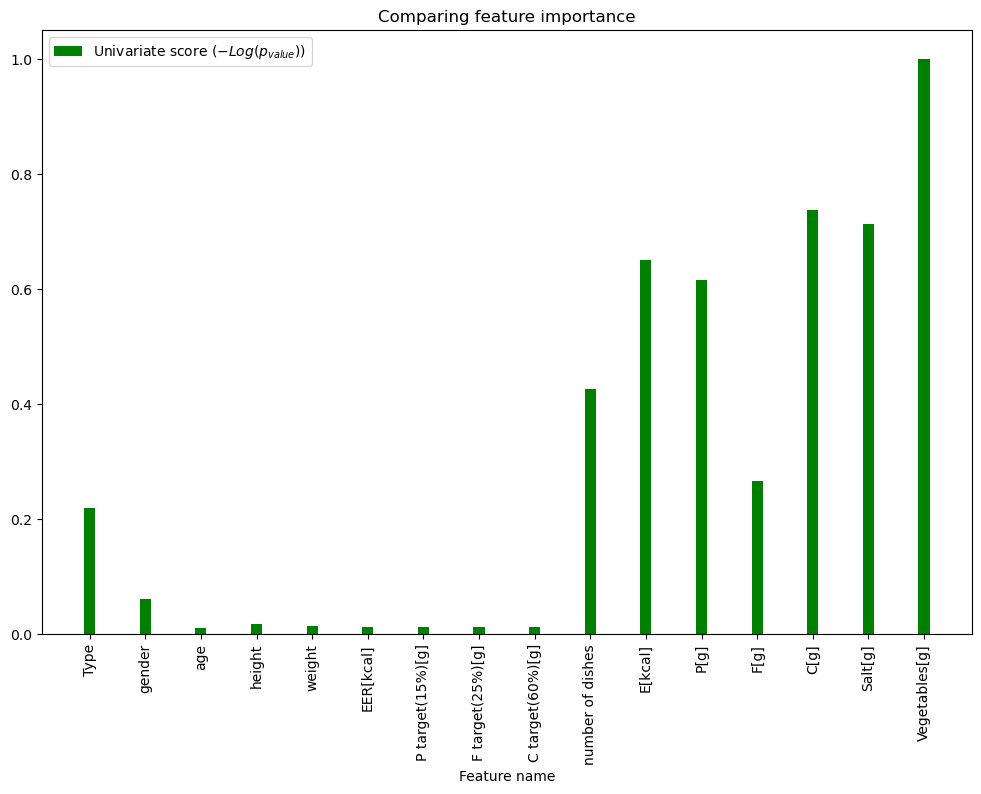

In [9]:
selector = SelectPercentile(f_classif)
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
X_indices = np.arange(X.shape[-1])

%matplotlib inline
fig=plt.figure(figsize=(12,8), dpi= 100)
plt.bar(X_indices, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='g')
plt.title("Comparing feature importance")
plt.xlabel('Feature name')
plt.xticks(ticks=X_indices, labels=feature_names, rotation=90)
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

## Remove less important features to see if the accuracy is increased
After removing the less important features, the accuracy is increased from 77% to 82%. 

So that our final model is shown as below. 

It is trained with 8 features: Type, gender, number of dishes, E, P, F, C, Salt and Vegetables.
The algorithm is SVM with rbf kernel, with a C parameter of 10 and gamma parameter of 0.1.

In [12]:
# delete unimportant features to see if accuracy increased
X_train_fs = np.delete(X_train, [2, 3, 4, 5, 6, 7, 8], 1)
X_test_fs = np.delete(X_test, [2, 3, 4, 5, 6, 7, 8], 1)


# Instantiate the GridSearchCV object: cv_fs 
cv_fs = GridSearchCV(clf_pipeline, param_grid=parameters, cv=5, n_jobs=-1)

# Fit to the training set
cv_fs.fit(X_train_fs, y_train)

print("Tuned Model Parameters: {}".format(cv_fs.best_params_))
print("Best Accuracy: {:.2%}".format(cv_fs.best_score_))


# Apply model on testing data and finding accuracy on it.
y_pred = cv_fs.predict(X_test_fs)

# Compute and print metrics
print(confusion_matrix(y_test, y_pred))
print("Accuracy on test set after feature selection: {:.2%}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Tuned Model Parameters: {'clf__estimator__C': 10, 'clf__estimator__gamma': 0.1}
Best Accuracy: 78.88%
[[ 43  12   0   0]
 [  6 148  11   0]
 [  0  14  22   0]
 [  0   1   3   3]]
Accuracy on test set after feature selection: 82.13%
              precision    recall  f1-score   support

           1       0.88      0.78      0.83        55
           2       0.85      0.90      0.87       165
           3       0.61      0.61      0.61        36
           4       1.00      0.43      0.60         7

    accuracy                           0.82       263
   macro avg       0.83      0.68      0.73       263
weighted avg       0.82      0.82      0.82       263



## Summary
### What makes a good meal
From the feature selection with F test, we found that features of personal profile such age, height, and weight, are relatively less important to the score.
In addition, Energy, Protein, Fat and Carbo are unimportant to the score too.

The gender has low importance, suggesting that gender has little thing to do with the score.
The type of meal also has relatively low importance, suggesting that all nutritions such as protein, fat, carbo, etc should be taken throughout the day in every meal.

What matters the most to the meal is the meal's own characteristies.
Among them, vegetables shows the highest importance. Energy, Protein, Carbo and Salt are almost equally important.
We should make sure to have enough of these four for better health.
The amount of Fat is not so important. The number of dishes also have influence on the meal. I guess that the more dishes a meal has, the more balanced and nutritious the meal will be.

### Improve the classifier accuracy
The confusion matrix shows that the classification accuracy of score 3 and 4 are relativley low.
That is presumably because the original data set has less examples of score 3 and 4.
If we could collect more data sets of score 3 and 4, the classificaton accuracy could be imporved.

Of course, adding more features and collect more overall data sets can also improve the classification accuracy. For example, we have target energy, protein, fat, carbo and salt a user should take in a day, if we know the target energy, protein, fat, carbo and salt a user should take for each meal, that might improve the classification accuracy. 